In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime
import time
import matplotlib.pyplot as plt

C:\Users\HUAWEI\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Parsing | Data selection | Parsing

##### Parsing of city names

In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36"
}

cities = []
full_link = 'https://pogoda.mail.ru/country/kazakhstan/'
response = requests.get(full_link, headers=headers)

html_content = response.content
soup = BeautifulSoup(html_content, "html.parser")

a_elements = soup.find_all("span", class_="city-list__val city-list__val-text")

for a_element in a_elements:
    href = a_element.a["href"]

    city_name = href.rsplit("/", 2)[-2]
    cities.append(city_name)

print(len(cities))


101


In [109]:
df = pd.DataFrame(cities)
df.to_csv('cities.csv')
df.to_excel('cities.xlsx')

In [56]:
cities = pd.read_csv('cities.csv')

In [3]:
cities

['abay',
 'novokazalinsk',
 'akkol',
 'aksay',
 'aktau',
 'aktobe',
 'alga',
 'almaty',
 'aralsk',
 'arkalyk',
 'arshaly',
 'astana',
 'astrakhanka',
 'atasu',
 'atbasar',
 'atyrau',
 'auliekol',
 'ayagoz',
 'baykonur',
 'balkashino',
 'balkhash',
 'bayanayl',
 'borovoe',
 'borodulikha',
 'bulaevo',
 'derzhavinsk',
 'egindykol',
 'ereymentau',
 'esik',
 'esil',
 'zhaksy',
 'zhanakorgan',
 'zhanaozen',
 'zhanatas',
 'zharkent',
 'zhezkazgan',
 'zhetysay',
 'zhitikara',
 'zerenda',
 'zyryanovsk',
 'inderborskiy',
 'irtyshsk',
 'kazalinsk',
 'kazyrgut',
 'kandagach',
 'kapchagay',
 'karabalyk',
 'karaganda',
 'karatau',
 'karkaraly',
 'kaskelen',
 'kokshetay',
 'kostanay',
 'kulsary',
 'kurchatow',
 'kyzylorda',
 'lenger',
 'lisakovsk',
 'makinsk',
 'mamlyutka',
 'martuk',
 'merke',
 'novoishimskoe',
 'osakarovka',
 'pavlodar',
 'petropavlovsk_kazakhstan',
 'presnovka',
 'ridder',
 'rudny',
 'ruzaevka_kazakhstan',
 'sarkand',
 'saryagash',
 'sarykol',
 'saumalkol',
 'semipalatinsk',
 'ser

##### Parsing of main part

In [24]:
df = pd.DataFrame(columns=['day','month','year','city', 'temp', 'weather', 'feel_temp', 'pressure', 'humidity', 'wind', 'type_of_day'])

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36"
}

def get_url(day, month, city):
    url = f"https://pogoda.mail.ru/prognoz/{city}/{day}-{month}/"
    return url

def scrape_weather(day, month, city):
    url = get_url(day, month, city)
    response = requests.get(url, headers=headers)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")
    general = soup.find_all('div', class_='cols__column__inner')
    result = {}
    for day_info in general[2:]:
        date_info = day_info.find('div', class_='heading heading_minor heading_line').text.strip().split()
        day_name = date_info[0]
        month_name = date_info[1]
        year_name = date_info[2]  
        types = day_info.find_all('div', class_='day day_period')
        day_data = {}  
        for type_ in types:
            type_of_day = type_.find('div', class_='day__date').text.strip()
            temp = type_.find('div', class_='day__temperature').text.strip()
            spans = type_.find('div', class_='day__description').find_all('span')
            weather = spans[0].text.strip()
            feel_temp = spans[1].text.strip().replace('ощущается как', '').strip()  
            days_add = type_.find_all('div', class_='day__additional')
            
            pressure = days_add[0].find('span')
            pressure = pressure.text.replace('\n', '').replace('\t', '').strip() if pressure else 'N/A'
                
            humidity = days_add[1].find('span')
            humidity = humidity.text.replace('\n', '').replace('\t', '').strip() if humidity else 'N/A'
            
            wind = days_add[2].find('span')
            wind = wind.text.replace('\n', '').replace('\t', '').strip() if wind else 'N/A'
            
            day_data[type_of_day] = {
                'Day': day_name,
                'Month': month_name,
                'Year': year_name,
                'Type_of_day': type_of_day,
                'temperature': temp,
                'weather': weather,
                'feel_temperature': feel_temp,
                'pressure': pressure,
                'humidity': humidity,
                'wind': wind
            }
        
        result[f"{day_name} {month_name} {year_name}"] = day_data
        
    return result

days_in_month = {
    "january": 31,
    "february": 28,
    "march": 31,
    "april": 30,
    "may": 31,
    "june": 30,
    "july": 31,
    "august": 31,
    "september": 30,
    "october": 31,
    "november": 30,
    "december": 31
}

cities = [
    'almaty', 'astana', 'shymkent', 'karaganda', 'aktobe', 'pavlodar', 'ust_kamenogorsk', 'kostanay', 'kokshetay',
    'atyrau', 'ekibastuz', 'uralsk', 'taraz', 'petropavlovsk_kazakhstan', 'semipalatinsk', 'turkestan', 'aktau',
    'kyzylorda', 'kapchagay', 'temirtau'
]

for city in cities:
    for month in days_in_month:
        for day in range(1, days_in_month[month] + 1):
            weather_data = scrape_weather(day, month, city)
            for date, data in weather_data.items():
                day_name, month_name, year_name = date.split()  
                for time_of_day, weather_info in data.items():
                    temp = weather_info['temperature']
                    weather = weather_info['weather']
                    feel_temp = weather_info['feel_temperature']
                    pressure = weather_info['pressure']
                    humidity = weather_info['humidity']
                    wind = weather_info['wind']
                    type_of_day = time_of_day
                    df.loc[len(df)] = [day_name, month_name, year_name, city.capitalize(), temp, weather, feel_temp, pressure, humidity, wind, type_of_day]
            
            time.sleep(0.5)


Scraping: https://pogoda.mail.ru/prognoz/almaty/1-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/2-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/3-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/4-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/5-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/6-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/7-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/8-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/9-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/10-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/11-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/12-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/13-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/14-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/15-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/16-january/
Scraping: https://pogoda.mail.ru/prognoz/almaty/1

KeyboardInterrupt: 

In [25]:
df

,day,month,year,city,temp,weather,feel_temp,pressure,humidity,wind,type_of_day
0,1,января,2024,Almaty,-5°,"туман, изморозь",-8°C,691 мм,93%,2 м/с,Ночью
1,1,января,2024,Almaty,-6°,ясно,-10°C,690 мм,86%,2 м/с,Утром
2,1,января,2024,Almaty,+4°,ясно,+2°C,690 мм,56%,1 м/с,Днем
3,1,января,2024,Almaty,-3°,ясно,-6°C,686 мм,86%,2 м/с,Вечером
4,1,января,2023,Almaty,-3°,ливневый снег,-6°C,699 мм,100%,2 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
305327,21,апреля,2013,Petropavlovsk_kazakhstan,+8°,облачно,+5°C,749 мм,89%,1 м/с,Вечером
305328,21,апреля,2012,Petropavlovsk_kazakhstan,+6°,облачно,+1°C,754 мм,61%,4 м/с,Ночью
305329,21,апреля,2012,Petropavlovsk_kazakhstan,+4°,ясно,-3°C,753 мм,52%,8 м/с,Утром
305330,21,апреля,2012,Petropavlovsk_kazakhstan,+9°,ясно,+4°C,756 мм,21%,5 м/с,Днем


In [31]:
df.to_csv('weathers_petropsvlovsk_kazakhstan_21_april.csv')
df.to_excel('weathers_petropsvlovsk_kazakhstan_21_april.xlsx')


In [33]:
df1 = df

In [34]:
df1

,day,month,year,city,temp,weather,feel_temp,pressure,humidity,wind,type_of_day
0,1,января,2024,Almaty,-5°,"туман, изморозь",-8°C,691 мм,93%,2 м/с,Ночью
1,1,января,2024,Almaty,-6°,ясно,-10°C,690 мм,86%,2 м/с,Утром
2,1,января,2024,Almaty,+4°,ясно,+2°C,690 мм,56%,1 м/с,Днем
3,1,января,2024,Almaty,-3°,ясно,-6°C,686 мм,86%,2 м/с,Вечером
4,1,января,2023,Almaty,-3°,ливневый снег,-6°C,699 мм,100%,2 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
305327,21,апреля,2013,Petropavlovsk_kazakhstan,+8°,облачно,+5°C,749 мм,89%,1 м/с,Вечером
305328,21,апреля,2012,Petropavlovsk_kazakhstan,+6°,облачно,+1°C,754 мм,61%,4 м/с,Ночью
305329,21,апреля,2012,Petropavlovsk_kazakhstan,+4°,ясно,-3°C,753 мм,52%,8 м/с,Утром
305330,21,апреля,2012,Petropavlovsk_kazakhstan,+9°,ясно,+4°C,756 мм,21%,5 м/с,Днем


In [38]:
df = pd.DataFrame(columns=['day','month','year','city', 'temp', 'weather', 'feel_temp', 'pressure', 'humidity', 'wind', 'type_of_day'])

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36"
}

def get_url(day, month, city):
    url = f"https://pogoda.mail.ru/prognoz/{city}/{day}-{month}/"
    return url

def scrape_weather(day, month, city):
    url = get_url(day, month, city)
    response = requests.get(url, headers=headers)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")
    general = soup.find_all('div', class_='cols__column__inner')
    result = {}
    for day_info in general[2:]:
        date_info = day_info.find('div', class_='heading heading_minor heading_line').text.strip().split()
        day_name = date_info[0]
        month_name = date_info[1]
        year_name = date_info[2]  
        types = day_info.find_all('div', class_='day day_period')
        day_data = {} 
        for type_ in types:
            type_of_day = type_.find('div', class_='day__date').text.strip()
            temp = type_.find('div', class_='day__temperature').text.strip()
            spans = type_.find('div', class_='day__description').find_all('span')
            weather = spans[0].text.strip()
            feel_temp = spans[1].text.strip().replace('ощущается как', '').strip()  
            days_add = type_.find_all('div', class_='day__additional')
            
            pressure = days_add[0].find('span')
            pressure = pressure.text.replace('\n', '').replace('\t', '').strip() if pressure else 'N/A'
                
            humidity = days_add[1].find('span')
            humidity = humidity.text.replace('\n', '').replace('\t', '').strip() if humidity else 'N/A'
            
            wind = days_add[2].find('span')
            wind = wind.text.replace('\n', '').replace('\t', '').strip() if wind else 'N/A'
            
            day_data[type_of_day] = {
                'Day': day_name,
                'Month': month_name,
                'Year': year_name,
                'Type_of_day': type_of_day,
                'temperature': temp,
                'weather': weather,
                'feel_temperature': feel_temp,
                'pressure': pressure,
                'humidity': humidity,
                'wind': wind
            }
        
        result[f"{day_name} {month_name} {year_name}"] = day_data
        
    return result

days_in_month = {
    "january": 31,
    "february": 28,
    "march": 31,
    "april": 30,
    "may": 31,
    "june": 30,
    "july": 31,
    "august": 31,
    "september": 30,
    "october": 31,
    "november": 30,
    "december": 31
}

cities = [
    'almaty', 'astana', 'shymkent', 'karaganda', 'aktobe', 'pavlodar', 'ust_kamenogorsk', 'kostanay', 'kokshetay',
    'atyrau', 'ekibastuz', 'uralsk', 'taraz', 'petropavlovsk_kazakhstan', 'semipalatinsk', 'turkestan', 'aktau',
    'kyzylorda', 'kapchagay', 'temirtau'
]


for city in cities[cities.index('petropavlovsk_kazakhstan'):]:
    start_month = "march"
    start_day = 21
    start_month_index = list(days_in_month.keys()).index(start_month)
    for month_index, month in enumerate(list(days_in_month.keys())[start_month_index:], start=start_month_index):
        days = days_in_month[month]
        if month_index == start_month_index:
            days -= (start_day - 1)
        else:
            start_day = 1  
        for day in range(start_day, days + 1):
            weather_data = scrape_weather(day, month, city)
            for date, data in weather_data.items():
                day_name, month_name, year_name = date.split()  
                for time_of_day, weather_info in data.items():
                    temp = weather_info['temperature']
                    weather = weather_info['weather']
                    feel_temp = weather_info['feel_temperature']
                    pressure = weather_info['pressure']
                    humidity = weather_info['humidity']
                    wind = weather_info['wind']
                    type_of_day = time_of_day
                    df.loc[len(df)] = [day_name, month_name, year_name, city.replace("_", " ").title(), temp, weather, feel_temp, pressure, humidity, wind, type_of_day]
            
            start_day = 1
            time.sleep(0.5)


Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/1-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/2-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/3-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/4-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/5-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/6-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/7-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/8-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/9-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/10-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/11-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/12-april/
Scraping: https://pogoda.mail.ru/prognoz/petropavlovsk_kazakhstan/13-april/
Scraping: https://pog

In [39]:
df

,day,month,year,city,temp,weather,feel_temp,pressure,humidity,wind,type_of_day
0,1,апреля,2024,Petropavlovsk Kazakhstan,+1°,осадки,-4°C,752 мм,95%,5 м/с,Ночью
1,1,апреля,2024,Petropavlovsk Kazakhstan,+1°,дождь со снегом,-5°C,750 мм,93%,9 м/с,Утром
2,1,апреля,2024,Petropavlovsk Kazakhstan,+2°,пасмурно,-4°C,750 мм,87%,9 м/с,Днем
3,1,апреля,2024,Petropavlovsk Kazakhstan,+2°,пасмурно,-4°C,750 мм,93%,8 м/с,Вечером
4,1,апреля,2023,Petropavlovsk Kazakhstan,-6°,облачно,-12°C,767 мм,85%,4 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
118979,31,декабря,2009,Temirtau,-4°,снег,-7°C,715 мм,97%,4 м/с,Вечером
118980,31,декабря,2008,Temirtau,-16°,облачно,-23°C,727 мм,98%,5 м/с,Ночью
118981,31,декабря,2008,Temirtau,-16°,облачно,-21°C,727 мм,97%,5 м/с,Утром
118982,31,декабря,2008,Temirtau,-15°,облачно,-22°C,726 мм,97%,5 м/с,Днем


In [40]:
df.to_csv('weather_rest.csv')

In [3]:
df_main = pd.read_csv("weathers_petropsvlovsk_kazakhstan_21_april.csv")
df_rest = pd.read_csv("weather_rest.csv")

df_combined = pd.concat([df_main, df_rest])
df_combined = df_combined.drop_duplicates()

   Unnamed: 0  day   month  year    city temp          weather feel_temp  \
0           0    1  января  2024  Almaty  -5°  туман, изморозь      -8°C   
1           1    1  января  2024  Almaty  -6°             ясно     -10°C   
2           2    1  января  2024  Almaty  +4°             ясно      +2°C   
3           3    1  января  2024  Almaty  -3°             ясно      -6°C   
4           4    1  января  2023  Almaty  -3°    ливневый снег      -6°C   

  pressure humidity   wind type_of_day  
0   691 мм      93%  2 м/с       Ночью  
1   690 мм      86%  2 м/с       Утром  
2   690 мм      56%  1 м/с        Днем  
3   686 мм      86%  2 м/с     Вечером  
4   699 мм     100%  2 м/с       Ночью  


In [4]:
df_combined

,Unnamed: 0,day,month,year,city,temp,weather,feel_temp,pressure,humidity,wind,type_of_day
0,0,1,января,2024,Almaty,-5°,"туман, изморозь",-8°C,691 мм,93%,2 м/с,Ночью
1,1,1,января,2024,Almaty,-6°,ясно,-10°C,690 мм,86%,2 м/с,Утром
2,2,1,января,2024,Almaty,+4°,ясно,+2°C,690 мм,56%,1 м/с,Днем
3,3,1,января,2024,Almaty,-3°,ясно,-6°C,686 мм,86%,2 м/с,Вечером
4,4,1,января,2023,Almaty,-3°,ливневый снег,-6°C,699 мм,100%,2 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...,...
118979,118979,31,декабря,2009,Temirtau,-4°,снег,-7°C,715 мм,97%,4 м/с,Вечером
118980,118980,31,декабря,2008,Temirtau,-16°,облачно,-23°C,727 мм,98%,5 м/с,Ночью
118981,118981,31,декабря,2008,Temirtau,-16°,облачно,-21°C,727 мм,97%,5 м/с,Утром
118982,118982,31,декабря,2008,Temirtau,-15°,облачно,-22°C,726 мм,97%,5 м/с,Днем


In [7]:
df_combined = pd.read_csv("full_weather.csv").drop(columns=["Unnamed: 0"])

df_combined.reset_index(drop=True, inplace=True)
df_combined

,day,month,year,city,temp,weather,feel_temp,pressure,humidity,wind,type_of_day
0,1,января,2024,Almaty,-5°,"туман, изморозь",-8°C,691 мм,93%,2 м/с,Ночью
1,1,января,2024,Almaty,-6°,ясно,-10°C,690 мм,86%,2 м/с,Утром
2,1,января,2024,Almaty,+4°,ясно,+2°C,690 мм,56%,1 м/с,Днем
3,1,января,2024,Almaty,-3°,ясно,-6°C,686 мм,86%,2 м/с,Вечером
4,1,января,2023,Almaty,-3°,ливневый снег,-6°C,699 мм,100%,2 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
424311,31,декабря,2009,Temirtau,-4°,снег,-7°C,715 мм,97%,4 м/с,Вечером
424312,31,декабря,2008,Temirtau,-16°,облачно,-23°C,727 мм,98%,5 м/с,Ночью
424313,31,декабря,2008,Temirtau,-16°,облачно,-21°C,727 мм,97%,5 м/с,Утром
424314,31,декабря,2008,Temirtau,-15°,облачно,-22°C,726 мм,97%,5 м/с,Днем


In [11]:
df_combined.to_csv("full_weather.csv", index=False)

# Data cleaning | Data collection part 2

In [20]:
df1 = pd.read_csv("cleaned_weather.csv")
df1

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,daytype,season,avg_temp,avg_pressure,avg_humidity,avg_wind,avg_feel,region
0,1,january,2024,Almaty,-5,"fog, hoarfrost",-8,691,93,2,night,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
1,1,january,2024,Almaty,-6,clear,-10,690,86,2,morning,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
2,1,january,2024,Almaty,4,clear,2,690,56,1,day,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
3,1,january,2024,Almaty,-3,clear,-6,686,86,2,evening,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
4,1,january,2023,Almaty,-3,snowstorm,-6,699,100,2,night,winter,-4.75,698.00,93.00,2.00,-8.00,almaty_o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424311,31,december,2009,Temirtau,-4,snow,-7,715,97,4,evening,winter,-4.75,716.50,96.00,2.75,-8.00,karagandy_o
424312,31,december,2008,Temirtau,-16,cloudy,-23,727,98,5,night,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o
424313,31,december,2008,Temirtau,-16,cloudy,-21,727,97,5,morning,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o
424314,31,december,2008,Temirtau,-15,cloudy,-22,726,97,5,day,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o


#### Deleting +,° from temp

In [4]:
df['temp'] = df['temp'].str.replace('°', '').str.replace('+', '').astype(int)

df

,day,month,year,city,temp,weather,feel_temp,pressure,humidity,wind,type_of_day
0,1,января,2024,Almaty,-5,"туман, изморозь",-8°C,691 мм,93%,2 м/с,Ночью
1,1,января,2024,Almaty,-6,ясно,-10°C,690 мм,86%,2 м/с,Утром
2,1,января,2024,Almaty,4,ясно,+2°C,690 мм,56%,1 м/с,Днем
3,1,января,2024,Almaty,-3,ясно,-6°C,686 мм,86%,2 м/с,Вечером
4,1,января,2023,Almaty,-3,ливневый снег,-6°C,699 мм,100%,2 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
424311,31,декабря,2009,Temirtau,-4,снег,-7°C,715 мм,97%,4 м/с,Вечером
424312,31,декабря,2008,Temirtau,-16,облачно,-23°C,727 мм,98%,5 м/с,Ночью
424313,31,декабря,2008,Temirtau,-16,облачно,-21°C,727 мм,97%,5 м/с,Утром
424314,31,декабря,2008,Temirtau,-15,облачно,-22°C,726 мм,97%,5 м/с,Днем


#### Deleting "+,°,C" from fell_temp and renaming to feel

In [5]:
df['feel_temp'] = df['feel_temp'].str.replace('°C', '').astype(int)

df.rename(columns={'feel_temp': 'feel'}, inplace=True)

df

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,type_of_day
0,1,января,2024,Almaty,-5,"туман, изморозь",-8,691 мм,93%,2 м/с,Ночью
1,1,января,2024,Almaty,-6,ясно,-10,690 мм,86%,2 м/с,Утром
2,1,января,2024,Almaty,4,ясно,2,690 мм,56%,1 м/с,Днем
3,1,января,2024,Almaty,-3,ясно,-6,686 мм,86%,2 м/с,Вечером
4,1,января,2023,Almaty,-3,ливневый снег,-6,699 мм,100%,2 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
424311,31,декабря,2009,Temirtau,-4,снег,-7,715 мм,97%,4 м/с,Вечером
424312,31,декабря,2008,Temirtau,-16,облачно,-23,727 мм,98%,5 м/с,Ночью
424313,31,декабря,2008,Temirtau,-16,облачно,-21,727 мм,97%,5 м/с,Утром
424314,31,декабря,2008,Temirtau,-15,облачно,-22,726 мм,97%,5 м/с,Днем


#### Deleting "мм" from pressure 

In [6]:
df['pressure'] = df['pressure'].str.replace(' мм', '').astype(int)

df

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,type_of_day
0,1,января,2024,Almaty,-5,"туман, изморозь",-8,691,93%,2 м/с,Ночью
1,1,января,2024,Almaty,-6,ясно,-10,690,86%,2 м/с,Утром
2,1,января,2024,Almaty,4,ясно,2,690,56%,1 м/с,Днем
3,1,января,2024,Almaty,-3,ясно,-6,686,86%,2 м/с,Вечером
4,1,января,2023,Almaty,-3,ливневый снег,-6,699,100%,2 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
424311,31,декабря,2009,Temirtau,-4,снег,-7,715,97%,4 м/с,Вечером
424312,31,декабря,2008,Temirtau,-16,облачно,-23,727,98%,5 м/с,Ночью
424313,31,декабря,2008,Temirtau,-16,облачно,-21,727,97%,5 м/с,Утром
424314,31,декабря,2008,Temirtau,-15,облачно,-22,726,97%,5 м/с,Днем


#### Deleting "%" from humidity

In [7]:
df['humidity'] = df['humidity'].str.replace('%', '').astype(int)

df

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,type_of_day
0,1,января,2024,Almaty,-5,"туман, изморозь",-8,691,93,2 м/с,Ночью
1,1,января,2024,Almaty,-6,ясно,-10,690,86,2 м/с,Утром
2,1,января,2024,Almaty,4,ясно,2,690,56,1 м/с,Днем
3,1,января,2024,Almaty,-3,ясно,-6,686,86,2 м/с,Вечером
4,1,января,2023,Almaty,-3,ливневый снег,-6,699,100,2 м/с,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
424311,31,декабря,2009,Temirtau,-4,снег,-7,715,97,4 м/с,Вечером
424312,31,декабря,2008,Temirtau,-16,облачно,-23,727,98,5 м/с,Ночью
424313,31,декабря,2008,Temirtau,-16,облачно,-21,727,97,5 м/с,Утром
424314,31,декабря,2008,Temirtau,-15,облачно,-22,726,97,5 м/с,Днем


#### Deleting "м/с" from wind

In [8]:
df['wind'] = df['wind'].str.replace(' м/с', '').astype(int)

df

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,type_of_day
0,1,января,2024,Almaty,-5,"туман, изморозь",-8,691,93,2,Ночью
1,1,января,2024,Almaty,-6,ясно,-10,690,86,2,Утром
2,1,января,2024,Almaty,4,ясно,2,690,56,1,Днем
3,1,января,2024,Almaty,-3,ясно,-6,686,86,2,Вечером
4,1,января,2023,Almaty,-3,ливневый снег,-6,699,100,2,Ночью
...,...,...,...,...,...,...,...,...,...,...,...
424311,31,декабря,2009,Temirtau,-4,снег,-7,715,97,4,Вечером
424312,31,декабря,2008,Temirtau,-16,облачно,-23,727,98,5,Ночью
424313,31,декабря,2008,Temirtau,-16,облачно,-21,727,97,5,Утром
424314,31,декабря,2008,Temirtau,-15,облачно,-22,726,97,5,Днем


#### Renaming type_of_day to daytype

In [9]:
df.rename(columns={'type_of_day': 'daytype'}, inplace=True)

#### Replacing Russian meanings with their English translation

In [10]:
month_dict = {
    'января': 'january',
    'февраля': 'february',
    'марта': 'march',
    'апреля': 'april',
    'мая': 'may',
    'июня': 'june',
    'июля': 'july',
    'августа': 'august',
    'сентября': 'september',
    'октября': 'october',
    'ноября': 'november',
    'декабря': 'december'
}

df['month'] = df['month'].replace(month_dict)

daytype_dict = {
    'Ночью': 'night',
    'Утром': 'morning',
    'Днем': 'day',
    'Вечером': 'evening'
}

df['daytype'] = df['daytype'].replace(daytype_dict)

In [11]:
unique_weather = df['weather'].unique()
print(unique_weather)

['туман, изморозь' 'ясно' 'ливневый снег' 'пасмурно' 'облачность'
 'облачно' 'слабая морось' 'сильный туман' 'туман' 'слабый снег'
 'малооблачно' 'слабый дождь' 'дождь со снегом' 'снег' 'дождь'
 'местами туман' 'снежные зерна' 'ливневая крупа' 'мгла' 'дождь, гололед'
 'замерз. морось' 'морось' 'сильный снег' 'ливневый дождь' 'гроза'
 'пыль в воздухе' 'дождь/гроза' 'сильная гроза' 'шквал' 'пыль, ветер'
 'неба не видно' 'поземок' 'ледяные иглы' 'метель' 'сильная метель'
 'снежинки' 'сильный поземок' 'град, крупа' 'ливень' 'осадки' 'зарница'
 'пыльная буря' 'дождь, гроза' 'ледяной дождь' 'временами дождь'
 'сильный град' 'сильная морось' 'гроза, град' 'временами снег'
 'гроза, пыльная буря' 'сильный дождь' 'смерч' 'пыльные вихри'
 'морось с дождем']


In [12]:
weather_dict = {
    'туман, изморозь': 'fog, hoarfrost',
    'ясно': 'clear',
    'ливневый снег': 'snowstorm',
    'пасмурно': 'cloudy',
    'облачность': 'cloudiness',
    'облачно': 'cloudy',
    'слабая морось': 'light rain',
    'сильный туман': 'dense fog',
    'туман': 'fog',
    'слабый снег': 'light snow',
    'малооблачно': 'partly cloudy',
    'слабый дождь': 'light rain',
    'дождь со снегом': 'sleet',
    'снег': 'snow',
    'дождь': 'rain',
    'местами туман': 'patchy fog',
    'снежные зерна': 'snow grains',
    'ливневая крупа': 'hail',
    'мгла': 'haze',
    'дождь, гололед': 'freezing rain',
    'замерз. морось': 'freezing drizzle',
    'морось': 'drizzle',
    'сильный снег': 'heavy snow',
    'ливневый дождь': 'downpour',
    'гроза': 'thunderstorm',
    'пыль в воздухе': 'dust in the air',
    'дождь, гроза': 'rain, thunderstorm',
    'сильная гроза': 'severe thunderstorm',
    'шквал': 'squall',
    'пыль, ветер': 'dust, wind',
    'неба не видно': 'no sky visible',
    'поземок': 'fog over the ground',
    'ледяные иглы': 'ice needles',
    'метель': 'blizzard',
    'сильная метель': 'severe blizzard',
    'снежинки': 'snowflakes',
    'сильный поземок': 'dense ground fog',
    'град, крупа': 'hail, slush',
    'ливень': 'heavy rain',
    'осадки': 'precipitation',
    'зарница': 'lightning',
    'пыльная буря': 'dust storm',
    'ледяной дождь': 'freezing rain',
    'временами дождь': 'occasional rain',
    'сильный град': 'heavy hail',
    'сильная морось': 'heavy drizzle',
    'гроза, град': 'thunderstorm, hail',
    'временами снег': 'occasional snow',
    'гроза, пыльная буря': 'thunderstorm, dust storm',
    'сильный дождь': 'heavy rain',
    'смерч': 'tornado',
    'пыльные вихри': 'dust devils',
    'морось с дождем': 'drizzle with rain'
}

df['weather'] = df['weather'].replace(weather_dict)

df['weather'] = df['weather'].replace('дождь/гроза', 'rain, thunderstorm')

unique_weather = df['weather'].unique()

print(unique_weather)

['fog, hoarfrost' 'clear' 'snowstorm' 'cloudy' 'cloudiness' 'light rain'
 'dense fog' 'fog' 'light snow' 'partly cloudy' 'sleet' 'snow' 'rain'
 'patchy fog' 'snow grains' 'hail' 'haze' 'freezing rain'
 'freezing drizzle' 'drizzle' 'heavy snow' 'downpour' 'thunderstorm'
 'dust in the air' 'rain, thunderstorm' 'severe thunderstorm' 'squall'
 'dust, wind' 'no sky visible' 'fog over the ground' 'ice needles'
 'blizzard' 'severe blizzard' 'snowflakes' 'dense ground fog'
 'hail, slush' 'heavy rain' 'precipitation' 'lightning' 'dust storm'
 'occasional rain' 'heavy hail' 'heavy drizzle' 'thunderstorm, hail'
 'occasional snow' 'thunderstorm, dust storm' 'tornado' 'dust devils'
 'drizzle with rain']


# Data wrangling | New variables

##### Creating new "season" column

In [13]:
seasons_dict = {
    'december': 'winter',
    'january': 'winter',
    'february': 'winter',
    'march': 'spring',
    'april': 'spring',
    'may': 'spring',
    'june': 'summer',
    'july': 'summer',
    'august': 'summer',
    'september': 'autumn',
    'october': 'autumn',
    'november': 'autumn'
}

df['season'] = df['month'].map(seasons_dict)

df

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,daytype,season
0,1,january,2024,Almaty,-5,"fog, hoarfrost",-8,691,93,2,night,winter
1,1,january,2024,Almaty,-6,clear,-10,690,86,2,morning,winter
2,1,january,2024,Almaty,4,clear,2,690,56,1,day,winter
3,1,january,2024,Almaty,-3,clear,-6,686,86,2,evening,winter
4,1,january,2023,Almaty,-3,snowstorm,-6,699,100,2,night,winter
...,...,...,...,...,...,...,...,...,...,...,...,...
424311,31,december,2009,Temirtau,-4,snow,-7,715,97,4,evening,winter
424312,31,december,2008,Temirtau,-16,cloudy,-23,727,98,5,night,winter
424313,31,december,2008,Temirtau,-16,cloudy,-21,727,97,5,morning,winter
424314,31,december,2008,Temirtau,-15,cloudy,-22,726,97,5,day,winter


##### Creating new columns with parameters of weather for whole day

In [16]:
df['avg_temp'] = df.groupby(['day', 'month', 'year', 'city'])['temp'].transform('mean')

df['avg_pressure'] = df.groupby(['day', 'month', 'year', 'city'])['pressure'].transform('mean')

df['avg_humidity'] = df.groupby(['day', 'month', 'year', 'city'])['humidity'].transform('mean')

df['avg_wind'] = df.groupby(['day', 'month', 'year', 'city'])['wind'].transform('mean')

df['avg_feel'] = df.groupby(['day', 'month', 'year', 'city'])['feel'].transform('mean')

df

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,daytype,season,avg_temp,avg_pressure,avg_humidity,avg_wind,avg_feel
0,1,january,2024,Almaty,-5,"fog, hoarfrost",-8,691,93,2,night,winter,-2.50,689.25,80.25,1.75,-5.50
1,1,january,2024,Almaty,-6,clear,-10,690,86,2,morning,winter,-2.50,689.25,80.25,1.75,-5.50
2,1,january,2024,Almaty,4,clear,2,690,56,1,day,winter,-2.50,689.25,80.25,1.75,-5.50
3,1,january,2024,Almaty,-3,clear,-6,686,86,2,evening,winter,-2.50,689.25,80.25,1.75,-5.50
4,1,january,2023,Almaty,-3,snowstorm,-6,699,100,2,night,winter,-4.75,698.00,93.00,2.00,-8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424311,31,december,2009,Temirtau,-4,snow,-7,715,97,4,evening,winter,-4.75,716.50,96.00,2.75,-8.00
424312,31,december,2008,Temirtau,-16,cloudy,-23,727,98,5,night,winter,-15.75,726.50,96.75,5.00,-22.25
424313,31,december,2008,Temirtau,-16,cloudy,-21,727,97,5,morning,winter,-15.75,726.50,96.75,5.00,-22.25
424314,31,december,2008,Temirtau,-15,cloudy,-22,726,97,5,day,winter,-15.75,726.50,96.75,5.00,-22.25


##### Creating new "region" column

In [17]:
city_regions = {
    'Almaty': 'almaty_o',
    'Kapchagay': 'almaty_o',
    'Ust_kamenogorsk': 'shygys',
    'Semipalatinsk': 'shygys',
    'Atyrau': 'atyrau_o',
    'Uralsk': 'batys',
    'Aktobe': 'aktobe_o',
    'Aktau': 'mangystau',
    'Kyzylorda': 'kyzylorda_o',
    'Turkestan': 'turkestan_o',
    'Shymkent': 'turkestan_o',
    'Taraz': 'zhambyl_o',
    'Karaganda': 'karagandy_o',
    'Temirtau': 'karagandy_o',
    'Pavlodar': 'pavlodar_o',
    'Ekibastuz': 'pavlodar_o',
    'Kostanay': 'kostanay_o',
    'Kokshetay': 'akmola_o',
    'Astana': 'akmola_o',
    'Petropavlovsk Kazakhstan': 'soltustik'
}

df['region'] = df['city'].map(city_regions)

df

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,daytype,season,avg_temp,avg_pressure,avg_humidity,avg_wind,avg_feel,region
0,1,january,2024,Almaty,-5,"fog, hoarfrost",-8,691,93,2,night,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
1,1,january,2024,Almaty,-6,clear,-10,690,86,2,morning,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
2,1,january,2024,Almaty,4,clear,2,690,56,1,day,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
3,1,january,2024,Almaty,-3,clear,-6,686,86,2,evening,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
4,1,january,2023,Almaty,-3,snowstorm,-6,699,100,2,night,winter,-4.75,698.00,93.00,2.00,-8.00,almaty_o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424311,31,december,2009,Temirtau,-4,snow,-7,715,97,4,evening,winter,-4.75,716.50,96.00,2.75,-8.00,karagandy_o
424312,31,december,2008,Temirtau,-16,cloudy,-23,727,98,5,night,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o
424313,31,december,2008,Temirtau,-16,cloudy,-21,727,97,5,morning,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o
424314,31,december,2008,Temirtau,-15,cloudy,-22,726,97,5,day,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o


##### Renaming columns for comfort work with them in Tableau

In [23]:
df1 = df.rename(columns=lambda x: x.replace('_', ''))

df1

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,daytype,season,avgtemp,avgpressure,avghumidity,avgwind,avgfeel,region
0,1,january,2024,Almaty,-5,"fog, hoarfrost",-8,691,93,2,night,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
1,1,january,2024,Almaty,-6,clear,-10,690,86,2,morning,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
2,1,january,2024,Almaty,4,clear,2,690,56,1,day,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
3,1,january,2024,Almaty,-3,clear,-6,686,86,2,evening,winter,-2.50,689.25,80.25,1.75,-5.50,almaty_o
4,1,january,2023,Almaty,-3,snowstorm,-6,699,100,2,night,winter,-4.75,698.00,93.00,2.00,-8.00,almaty_o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424311,31,december,2009,Temirtau,-4,snow,-7,715,97,4,evening,winter,-4.75,716.50,96.00,2.75,-8.00,karagandy_o
424312,31,december,2008,Temirtau,-16,cloudy,-23,727,98,5,night,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o
424313,31,december,2008,Temirtau,-16,cloudy,-21,727,97,5,morning,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o
424314,31,december,2008,Temirtau,-15,cloudy,-22,726,97,5,day,winter,-15.75,726.50,96.75,5.00,-22.25,karagandy_o


In [24]:
df1.to_csv('cleaned_weather_without_.csv', index=False)

##### Checking for Null values

In [6]:
df.isnull().sum()

day               0
month             0
year              0
city              0
temp              0
weather           0
feel              0
pressure          0
humidity          0
wind              0
daytype           0
season            0
avgtemp           0
avgpressure       0
avghumidity       0
avgwind           0
avgfeel           0
region         7092
dtype: int64

##### Fixing problem with Null values of "region" column

In [7]:
df[df['region'].isnull()]

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,daytype,season,avgtemp,avgpressure,avghumidity,avgwind,avgfeel,region
298240,1,january,2024,Petropavlovsk_kazakhstan,-2,cloudy,-6,737,93,6,night,winter,-0.25,738.00,90.50,7.50,-5.75,NaN
298241,1,january,2024,Petropavlovsk_kazakhstan,0,cloudy,-6,741,86,8,morning,winter,-0.25,738.00,90.50,7.50,-5.75,NaN
298242,1,january,2024,Petropavlovsk_kazakhstan,1,sleet,-5,736,93,9,day,winter,-0.25,738.00,90.50,7.50,-5.75,NaN
298243,1,january,2024,Petropavlovsk_kazakhstan,0,precipitation,-6,738,90,7,evening,winter,-0.25,738.00,90.50,7.50,-5.75,NaN
298244,1,january,2023,Petropavlovsk_kazakhstan,-18,snow,-24,760,97,3,night,winter,-22.50,758.50,86.75,2.75,-27.75,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305327,21,april,2013,Petropavlovsk_kazakhstan,8,cloudy,5,749,89,1,evening,spring,10.50,746.00,67.75,3.50,6.75,NaN
305328,21,april,2012,Petropavlovsk_kazakhstan,6,cloudy,1,754,61,4,night,spring,6.25,755.75,43.75,5.00,0.75,NaN
305329,21,april,2012,Petropavlovsk_kazakhstan,4,clear,-3,753,52,8,morning,spring,6.25,755.75,43.75,5.00,0.75,NaN
305330,21,april,2012,Petropavlovsk_kazakhstan,9,clear,4,756,21,5,day,spring,6.25,755.75,43.75,5.00,0.75,NaN


In [8]:
df[df['city']=='Petropavlovsk_kazakhstan']

,day,month,year,city,temp,weather,feel,pressure,humidity,wind,daytype,season,avgtemp,avgpressure,avghumidity,avgwind,avgfeel,region
298240,1,january,2024,Petropavlovsk_kazakhstan,-2,cloudy,-6,737,93,6,night,winter,-0.25,738.00,90.50,7.50,-5.75,NaN
298241,1,january,2024,Petropavlovsk_kazakhstan,0,cloudy,-6,741,86,8,morning,winter,-0.25,738.00,90.50,7.50,-5.75,NaN
298242,1,january,2024,Petropavlovsk_kazakhstan,1,sleet,-5,736,93,9,day,winter,-0.25,738.00,90.50,7.50,-5.75,NaN
298243,1,january,2024,Petropavlovsk_kazakhstan,0,precipitation,-6,738,90,7,evening,winter,-0.25,738.00,90.50,7.50,-5.75,NaN
298244,1,january,2023,Petropavlovsk_kazakhstan,-18,snow,-24,760,97,3,night,winter,-22.50,758.50,86.75,2.75,-27.75,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305327,21,april,2013,Petropavlovsk_kazakhstan,8,cloudy,5,749,89,1,evening,spring,10.50,746.00,67.75,3.50,6.75,NaN
305328,21,april,2012,Petropavlovsk_kazakhstan,6,cloudy,1,754,61,4,night,spring,6.25,755.75,43.75,5.00,0.75,NaN
305329,21,april,2012,Petropavlovsk_kazakhstan,4,clear,-3,753,52,8,morning,spring,6.25,755.75,43.75,5.00,0.75,NaN
305330,21,april,2012,Petropavlovsk_kazakhstan,9,clear,4,756,21,5,day,spring,6.25,755.75,43.75,5.00,0.75,NaN


In [9]:
df.loc[df['city'] == 'Petropavlovsk_kazakhstan', 'city'] = 'Petropavlovsk Kazakhstan'

df.loc[df['city'] == 'Petropavlovsk Kazakhstan', 'region'] = 'soltustik'

df.isnull().sum()

day            0
month          0
year           0
city           0
temp           0
weather        0
feel           0
pressure       0
humidity       0
wind           0
daytype        0
season         0
avgtemp        0
avgpressure    0
avghumidity    0
avgwind        0
avgfeel        0
region         0
dtype: int64

In [14]:
df['city'] = df['city'].replace('Petropavlovsk Kazakhstan', 'Petropavlovsk')

In [16]:
df.to_csv('weather.csv')

##### Detecting outliers using IQR method

In [25]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

numerical_columns = df.select_dtypes(include=[np.number]).columns
outliers = df[numerical_columns].apply(detect_outliers_iqr)

,day,year,temp,feel,pressure,humidity,wind,avgtemp,avgpressure,avghumidity,avgwind,avgfeel
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
424311,False,False,False,False,False,False,False,False,False,False,False,False
424312,False,False,False,False,False,False,False,False,False,False,False,False
424313,False,False,False,False,False,False,False,False,False,False,False,False
424314,False,False,False,False,False,False,False,False,False,False,False,False


In [26]:
outliers_count = outliers.sum()

outliers_count

day                0
year               0
temp             614
feel             333
pressure         270
humidity           0
wind           14011
avgtemp          696
avgpressure      340
avghumidity        0
avgwind        10972
avgfeel          160
dtype: int64

In [27]:
for column in outliers.columns:
    print(f"Аутлаеры в столбце '{column}':")
    print(df[outliers[column]][column])
    print()


Аутлаеры в столбце 'day':
Series([], Name: day, dtype: int64)

Аутлаеры в столбце 'year':
Series([], Name: year, dtype: int64)

Аутлаеры в столбце 'temp':
23724    -37
23725    -37
24445    -36
24509    -37
24565    -37
          ..
423336   -36
423400   -39
423401   -36
423403   -36
423467   -36
Name: temp, Length: 614, dtype: int64

Аутлаеры в столбце 'feel':
23724    -43
23932    -43
23933    -44
24573    -45
24575    -44
          ..
423272   -44
423274   -43
423275   -45
423336   -43
423400   -44
Name: feel, Length: 333, dtype: int64

Аутлаеры в столбце 'pressure':
12854       0
35844       0
82575       0
137804      0
150680    651
         ... 
405577      0
405578      0
405579      0
405624      0
405625      0
Name: pressure, Length: 270, dtype: int64

Аутлаеры в столбце 'humidity':
Series([], Name: humidity, dtype: int64)

Аутлаеры в столбце 'wind':
679       10
749       15
1239      11
1358      10
3950      10
          ..
424173    12
424188    12
424190    12
424191   

In [28]:
for column in outliers.columns:
    print(f"Минимальный аутлаер в столбце '{column}':")
    print(df[outliers[column]][column].min())
    print(f"Максимальный аутлаер в столбце '{column}':")
    print(df[outliers[column]][column].max())
    print('-----------------------------')


    
# We can coclude, that there is no outliers in this dataset, and values that gives us
# detect_outliers_iqr function are just true values of weather 

Минимальный аутлаер в столбце 'day':
nan
Максимальный аутлаер в столбце 'day':
nan
-----------------------------
Минимальный аутлаер в столбце 'year':
nan
Максимальный аутлаер в столбце 'year':
nan
-----------------------------
Минимальный аутлаер в столбце 'temp':
-45
Максимальный аутлаер в столбце 'temp':
-36
-----------------------------
Минимальный аутлаер в столбце 'feel':
-50
Максимальный аутлаер в столбце 'feel':
-43
-----------------------------
Минимальный аутлаер в столбце 'pressure':
0
Максимальный аутлаер в столбце 'pressure':
855
-----------------------------
Минимальный аутлаер в столбце 'humidity':
nan
Максимальный аутлаер в столбце 'humidity':
nan
-----------------------------
Минимальный аутлаер в столбце 'wind':
10
Максимальный аутлаер в столбце 'wind':
57
-----------------------------
Минимальный аутлаер в столбце 'avgtemp':
-43.0
Максимальный аутлаер в столбце 'avgtemp':
-33.5
-----------------------------
Минимальный аутлаер в столбце 'avgpressure':
0.0
Максимальны

# Exploring dataset using visualization methods

##### Temperature Distribution by Season

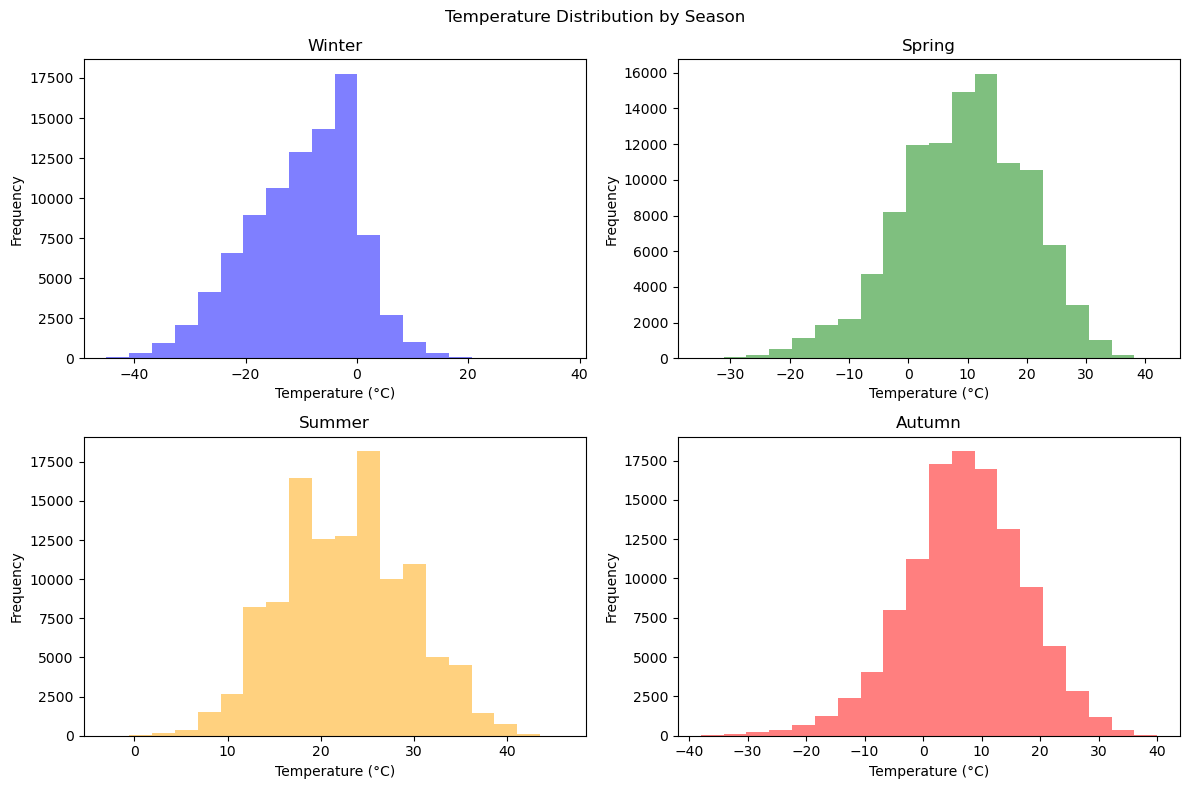

In [47]:
winter_temps = df[df['season'] == 'winter']['temp']
spring_temps = df[df['season'] == 'spring']['temp']
summer_temps = df[df['season'] == 'summer']['temp']
autumn_temps = df[df['season'] == 'autumn']['temp']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(winter_temps, bins=20, alpha=0.5, color='blue')
axs[0, 0].set_title('Winter')
axs[0, 1].hist(spring_temps, bins=20, alpha=0.5, color='green')
axs[0, 1].set_title('Spring')
axs[1, 0].hist(summer_temps, bins=20, alpha=0.5, color='orange')
axs[1, 0].set_title('Summer')
axs[1, 1].hist(autumn_temps, bins=20, alpha=0.5, color='red')
axs[1, 1].set_title('Autumn')

plt.suptitle('Temperature Distribution by Season')

for ax in axs.flat:
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Lowest and highest temperatures in each city

##### Effect of each weather parameter to another

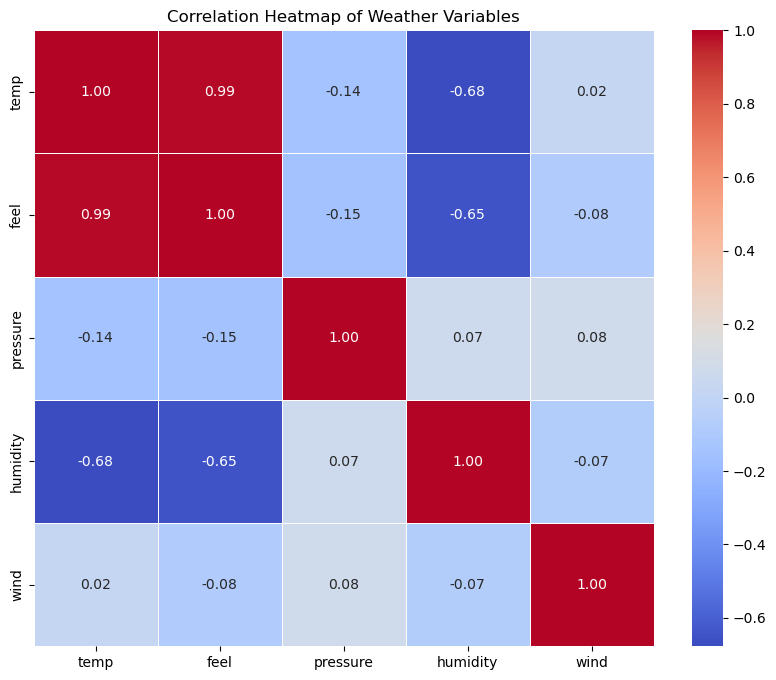

In [18]:
numerical_columns = ['temp', 'feel', 'pressure', 'humidity', 'wind']

correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Weather Variables')
plt.show()


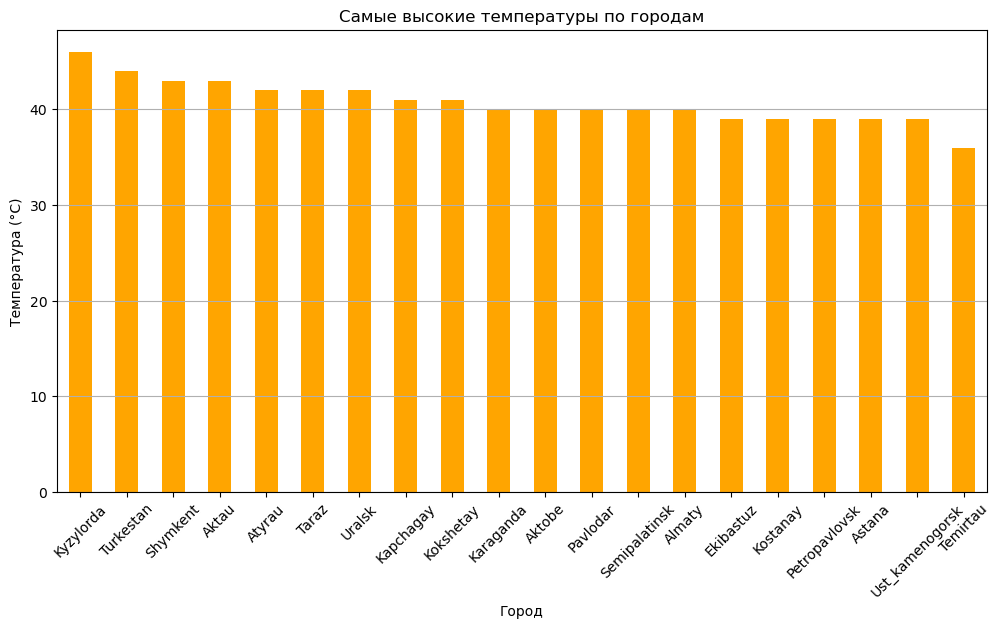

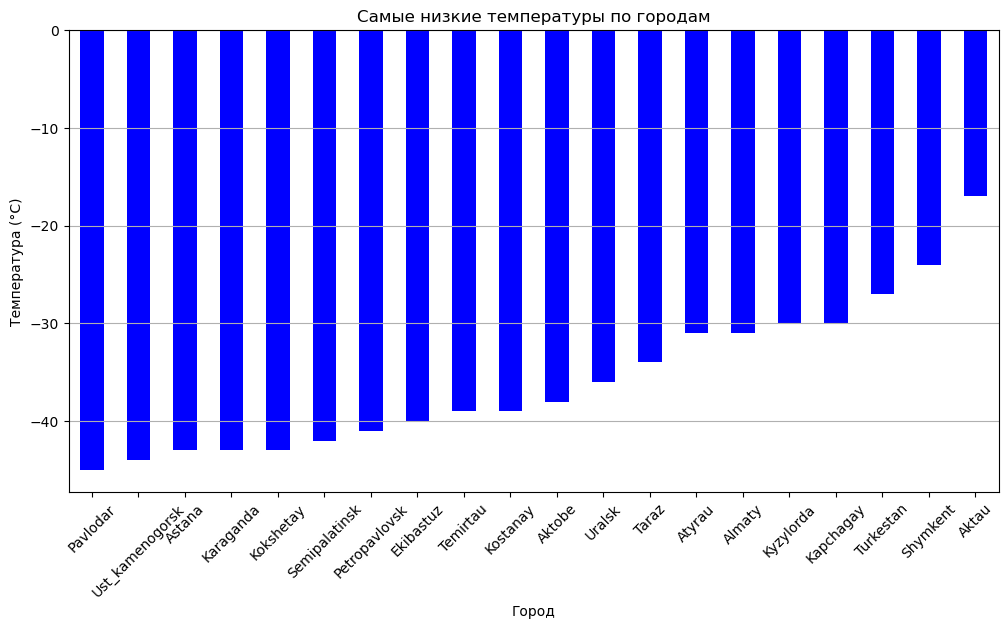

The highest temperatures in the cities:
city
Kyzylorda          46
Turkestan          44
Shymkent           43
Aktau              43
Atyrau             42
Taraz              42
Uralsk             42
Kapchagay          41
Kokshetay          41
Karaganda          40
Aktobe             40
Pavlodar           40
Semipalatinsk      40
Almaty             40
Ekibastuz          39
Kostanay           39
Petropavlovsk      39
Astana             39
Ust_kamenogorsk    39
Temirtau           36
Name: temp, dtype: int64

The lowest temperatures in the cities:
city
Pavlodar          -45
Ust_kamenogorsk   -44
Astana            -43
Karaganda         -43
Kokshetay         -43
Semipalatinsk     -42
Petropavlovsk     -41
Ekibastuz         -40
Temirtau          -39
Kostanay          -39
Aktobe            -38
Uralsk            -36
Taraz             -34
Atyrau            -31
Almaty            -31
Kyzylorda         -30
Kapchagay         -30
Turkestan         -27
Shymkent          -24
Aktau             -17
Name:

In [19]:
highest_temps = df.groupby('city')['temp'].max().sort_values(ascending=False)
lowest_temps = df.groupby('city')['temp'].min().sort_values()

plt.figure(figsize=(12, 6))
highest_temps.plot(kind='bar', color='orange')
plt.title('Самые высокие температуры по городам')
plt.xlabel('Город')
plt.ylabel('Температура (°C)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 6))
lowest_temps.plot(kind='bar', color='blue')
plt.title('Самые низкие температуры по городам')
plt.xlabel('Город')
plt.ylabel('Температура (°C)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

print("The highest temperatures in the cities:")
print(highest_temps)
print("\nThe lowest temperatures in the cities:")
print(lowest_temps)

##### Exploring change of Fell temperature 

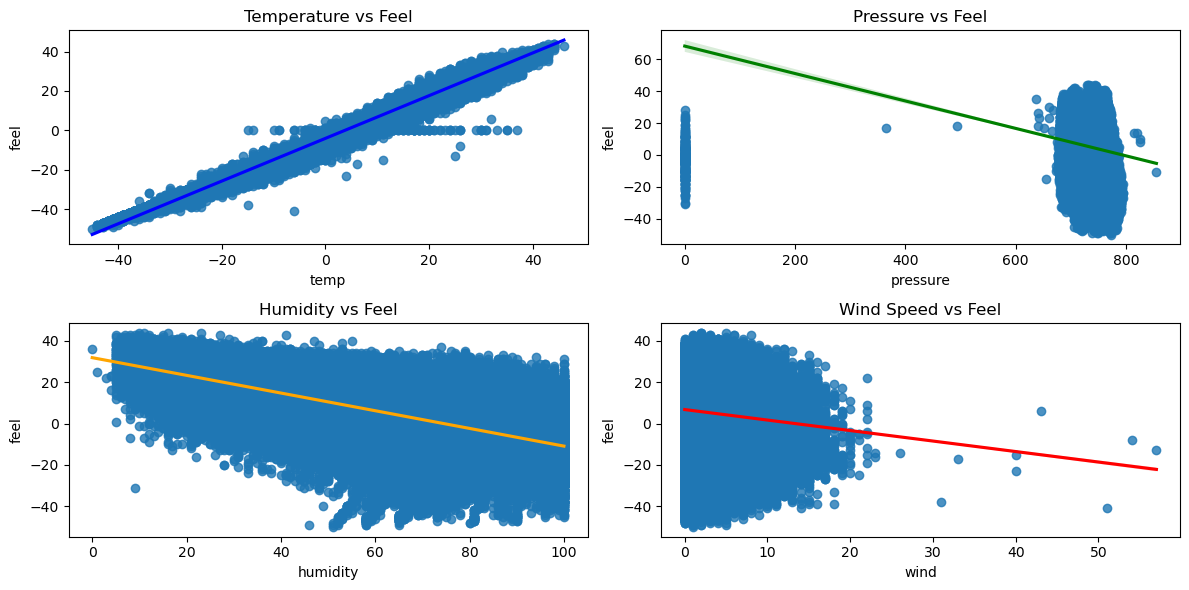

In [52]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.regplot(x='temp', y='feel', data=df, line_kws={"color": "blue"})
plt.title('Temperature vs Feel')

plt.subplot(2, 2, 2)
sns.regplot(x='pressure', y='feel', data=df, line_kws={"color": "green"})
plt.title('Pressure vs Feel')

plt.subplot(2, 2, 3)
sns.regplot(x='humidity', y='feel', data=df, line_kws={"color": "orange"})
plt.title('Humidity vs Feel')

plt.subplot(2, 2, 4)
sns.regplot(x='wind', y='feel', data=df, line_kws={"color": "red"})
plt.title('Wind Speed vs Feel')

plt.tight_layout()
plt.show()


# Analyzing and seeking evidence for problems of Global warming and Floods in Kazakhstan

##### Comparison of counts of precipitations in 2009-2010, 2014-2015, 2023-2024 winter. 

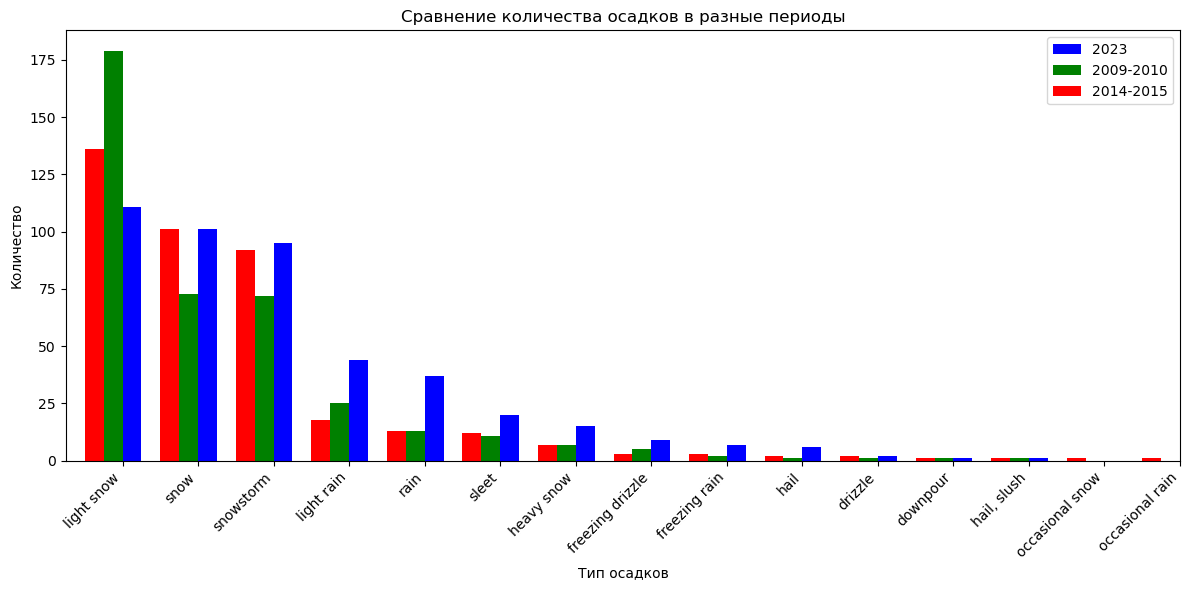

In [100]:
precipitation_counts_2023 = subset_precipitation_df['weather'].value_counts()
precipitation_counts_2009_2010 = subset_precipitation_df_winter_2009_2010['weather'].value_counts()
precipitation_counts_2014_2015 = subset_precipitation_df_winter_2014_2015['weather'].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))

precipitation_counts_2023.plot(kind='bar', color='b', position=0, width=0.25, label='2023', ax=ax)
precipitation_counts_2009_2010.plot(kind='bar', color='g', position=1, width=0.25, label='2009-2010', ax=ax)
precipitation_counts_2014_2015.plot(kind='bar', color='r', position=2, width=0.25, label='2014-2015', ax=ax)

plt.title('Сравнение количества осадков в разные периоды')
plt.xlabel('Тип осадков')
plt.ylabel('Количество')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Here we see that the total amount of precipitation is the most in 2023-2024 winter. 

In [95]:
subset_df = df[((df['year'] == 2023) & (df['month'].isin(['december']))) | ((df['year'] == 2024) & (df['month'].isin(['january', 'february', 'march']))) & (df['city'] == 'aktobe')]

precipitation_weather = ['light rain', 'snowstorm', 'light snow', 'sleet', 'snow', 'rain', 'drizzle', 'heavy snow', 'downpour', 'rain, thunderstorm', 'severe thunderstorm', 'hail', 'freezing rain', 'freezing drizzle', 'hail, slush', 'heavy rain', 'precipitation', 'heavy hail', 'heavy drizzle', 'thunderstorm, hail', 'thunderstorm, dust storm', 'occasional rain', 'thunderstorm', 'occasional snow', 'thunderstorm, dust storm']
subset_precipitation_df = subset_df[subset_df['weather'].isin(precipitation_weather)]

precipitation_counts = subset_precipitation_df['weather'].value_counts()

print(precipitation_counts)
print(' ')
print('Total number of precipitation', precipitation_counts.sum())

weather
light snow         111
snow               101
snowstorm           95
light rain          44
rain                37
sleet               20
precipitation       15
heavy snow           9
freezing rain        7
drizzle              6
downpour             2
hail                 1
occasional rain      1
Name: count, dtype: int64
 
Total number of precipitation 449


In [94]:
subset_df_winter_2009_2010 = df[((df['year'] == 2009) & (df['month'].isin(['december']))) | ((df['year'] == 2010) & (df['month'].isin(['january', 'february'])) & (df['city'] == 'aktobe'))]

precipitation_weather = ['light rain', 'snowstorm', 'light snow', 'sleet', 'snow', 'rain', 'drizzle', 'heavy snow', 'downpour', 'rain, thunderstorm', 'severe thunderstorm', 'hail', 'freezing rain', 'freezing drizzle', 'hail, slush', 'heavy rain', 'precipitation', 'heavy hail', 'heavy drizzle', 'thunderstorm, hail', 'thunderstorm, dust storm', 'occasional rain', 'thunderstorm', 'occasional snow', 'thunderstorm, dust storm']
subset_precipitation_df_winter_2009_2010 = subset_df_winter_2009_2010[subset_df_winter_2009_2010['weather'].isin(precipitation_weather)]

precipitation_counts_winter_2009_2010 = subset_precipitation_df_winter_2009_2010['weather'].value_counts()

print(precipitation_counts_winter_2009_2010)
print(' ')
print('Total number of precipitation', precipitation_counts_winter_2009_2010.sum())


weather
light snow          179
snowstorm            73
snow                 72
light rain           25
rain                 13
sleet                11
downpour              7
freezing rain         5
drizzle               2
hail, slush           1
freezing drizzle      1
hail                  1
occasional rain       1
Name: count, dtype: int64
 
Total number of precipitation 391


In [97]:
subset_df_winter_2014_2015 = df[((df['year'] == 2014) & (df['month'].isin(['december']))) | ((df['year'] == 2015) & (df['month'].isin(['january', 'february'])) & (df['city'] == 'aktobe'))]

precipitation_weather = ['light rain', 'snowstorm', 'light snow', 'sleet', 'snow', 'rain', 'drizzle', 'heavy snow', 'downpour', 'rain, thunderstorm', 'severe thunderstorm', 'hail', 'freezing rain', 'freezing drizzle', 'hail, slush', 'heavy rain', 'precipitation', 'heavy hail', 'heavy drizzle', 'thunderstorm, hail', 'thunderstorm, dust storm', 'occasional rain', 'thunderstorm', 'occasional snow', 'thunderstorm, dust storm']
subset_precipitation_df_winter_2014_2015 = subset_df_winter_2014_2015[subset_df_winter_2014_2015['weather'].isin(precipitation_weather)]

precipitation_counts_winter_2014_2015 = subset_precipitation_df_winter_2014_2015['weather'].value_counts()

print(precipitation_counts_winter_2014_2015)
print(' ')
print('Total number of precipitation', precipitation_counts_winter_2014_2015.sum())


weather
light snow          136
snow                101
snowstorm            92
light rain           18
rain                 13
sleet                12
heavy snow            7
freezing drizzle      3
freezing rain         3
hail                  2
drizzle               2
downpour              1
hail, slush           1
occasional snow       1
occasional rain       1
Name: count, dtype: int64
 
Total number of precipitation 393


##### Trends of humidity in Aktobe(march, april)

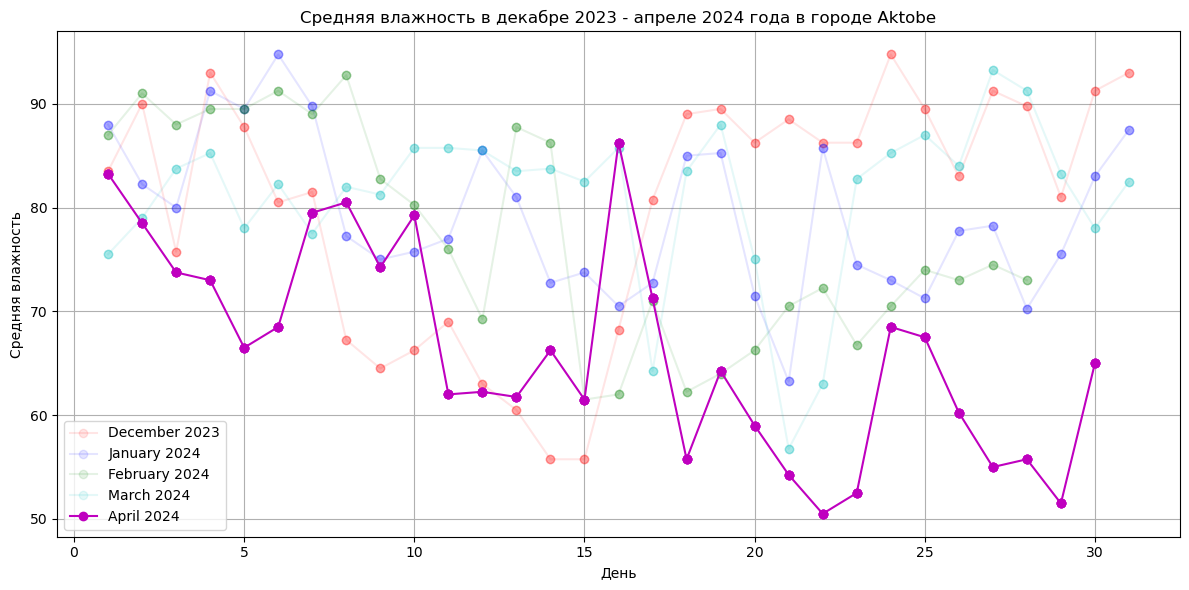

In [110]:
march_2024_aktobe = df[(df['year'] == 2024) & (df['month'] == 'march') & (df['city'] == 'Aktobe')]
april_2024_aktobe = df[(df['year'] == 2024) & (df['month'] == 'april') & (df['city'] == 'Aktobe')]
december_2023_aktobe = df[(df['year'] == 2023) & (df['month'] == 'december') & (df['city'] == 'Aktobe')]
january_2024_aktobe = df[(df['year'] == 2024) & (df['month'] == 'january') & (df['city'] == 'Aktobe')]
february_2024_aktobe = df[(df['year'] == 2024) & (df['month'] == 'february') & (df['city'] == 'Aktobe')]

plt.figure(figsize=(12, 6))

plt.plot(december_2023_aktobe['day'], december_2023_aktobe['avghumidity'], marker='o', linestyle='-', color='r', alpha=0.1, label='December 2023')
plt.plot(january_2024_aktobe['day'], january_2024_aktobe['avghumidity'], marker='o', linestyle='-', color='b', alpha=0.1, label='January 2024')
plt.plot(february_2024_aktobe['day'], february_2024_aktobe['avghumidity'], marker='o', linestyle='-', color='g', alpha=0.1, label='February 2024')
plt.plot(march_2024_aktobe['day'], march_2024_aktobe['avghumidity'], marker='o', linestyle='-', color='c', alpha=0.1, label='March 2024')
plt.plot(april_2024_aktobe['day'], april_2024_aktobe['avghumidity'], marker='o', linestyle='-', color='m', alpha=1.0, label='April 2024')

plt.title('Средняя влажность в декабре 2023 - апреле 2024 года в городе Aktobe')
plt.xlabel('День')
plt.ylabel('Средняя влажность')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#here we see that before the floods began in April, the percentage of humidity in Aktobe was increased for all 4 months

##### Percentage change of average temperature in 2015 and 2023

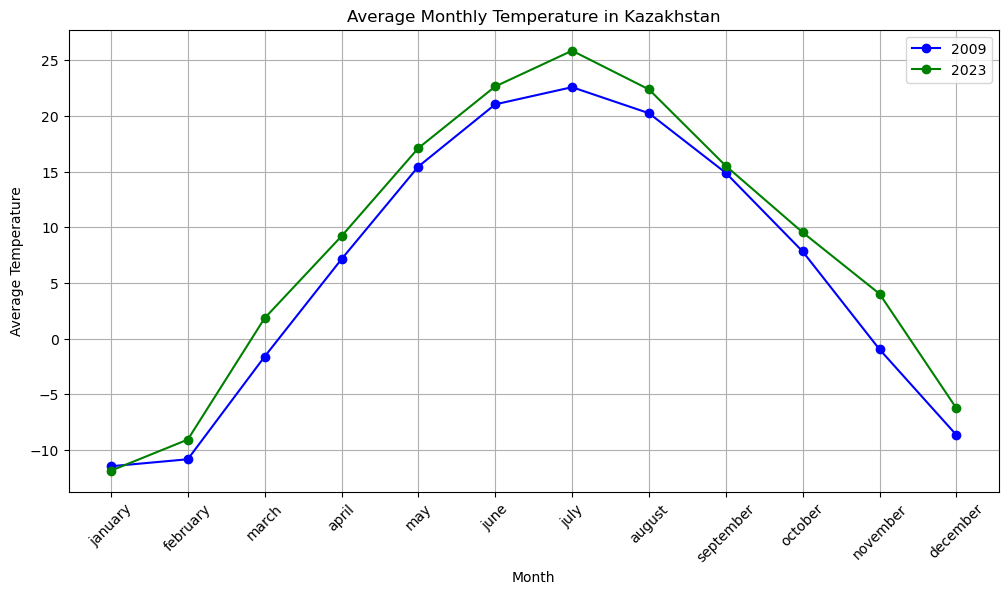

In [64]:
avg_temp_2009 = df[df['year'] == 2009].groupby('month')['temp'].mean()
avg_temp_2023 = df[df['year'] == 2023].groupby('month')['temp'].mean()

avg_temp_2009_sorted = avg_temp_2009.reindex(index=['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december'])
avg_temp_2023_sorted = avg_temp_2023.reindex(index=['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december'])

plt.figure(figsize=(12, 6))

plt.plot(avg_temp_2009_sorted.index, avg_temp_2009_sorted, marker='o', linestyle='-', color='b', label='2009')

plt.plot(avg_temp_2023_sorted.index, avg_temp_2023_sorted, marker='o', linestyle='-', color='g', label='2023')

plt.title('Average Monthly Temperature in Kazakhstan')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# If we talk about global warming, the average temperature in the country has increased by 33.5 percent since 2009

In [67]:
total_avg_temp_2009_rounded = round(avg_temp_2009.mean(), 2)
total_avg_temp_2023_rounded = round(avg_temp_2023.mean(), 2)

percent_change = ((total_avg_temp_2023_rounded - total_avg_temp_2009_rounded) / total_avg_temp_2009_rounded) * 100

print("Total Average Temperature in 2009:", total_avg_temp_2009_rounded)
print("Total Average Temperature in 2023:", total_avg_temp_2023_rounded)
print("Percentage Change from 2009 to 2023:", round(percent_change, 2))

Total Average Temperature in 2009: 6.3
Total Average Temperature in 2023: 8.41
Percentage Change from 2009 to 2023: 33.49


##### Comparison of count of weather types in 2009 and 2023

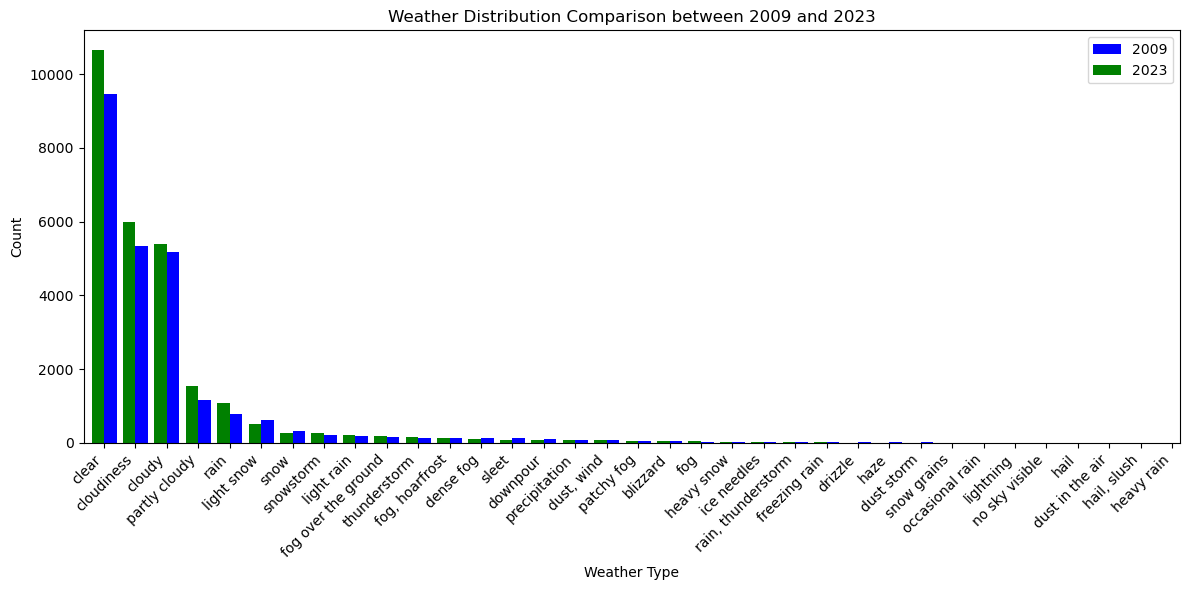

In [111]:
weather_count_2009 = df[df['year'] == 2009]['weather'].value_counts()
weather_count_2023 = df[df['year'] == 2023]['weather'].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))

weather_count_2009.plot(kind='bar', color='b', position=0, width=0.4, label='2009', ax=ax)
weather_count_2023.plot(kind='bar', color='g', position=1, width=0.4, label='2023', ax=ax)

plt.title('Weather Distribution Comparison between 2009 and 2023')
plt.xlabel('Weather Type')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# мы видим, что погода стала более экстремальной. Солнечных дней больше чем в 2009, но и дождей и облачных дней тоже больше.
# также можем наблюдать уменьшение количества снегопадов, что является следствием того, что погода зимой намного теплее 
# в 2023, чем в 2009

In [69]:
weather_comparison = pd.concat([weather_count_2009, weather_count_2023], axis=1, keys=['2009', '2023'])

print(weather_comparison)


                       2009     2023
weather                             
clear                9469.0  10654.0
cloudiness           5337.0   5999.0
cloudy               5169.0   5386.0
partly cloudy        1175.0   1531.0
rain                  785.0   1091.0
light snow            634.0    510.0
snowstorm             325.0    276.0
snow                  205.0    279.0
thunderstorm          184.0    162.0
fog, hoarfrost        157.0    142.0
downpour              145.0     80.0
light rain            141.0    221.0
fog over the ground   140.0    200.0
fog                   120.0     42.0
dense fog              98.0     97.0
snow grains            89.0      7.0
sleet                  69.0     87.0
dust, wind             61.0     65.0
patchy fog             45.0     50.0
ice needles            36.0     22.0
blizzard               26.0     46.0
drizzle                21.0     10.0
dust storm             15.0      8.0
occasional rain        15.0      5.0
freezing rain          13.0     17.0
s

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

df1 = df.drop(columns=['city', 'weather', 'daytype', 'region', 'day', 'year','region', 'avgfeel', 'avgwind', 'avghumidity',
                      'avgpressure','avgtemp','month', 'season'])

X = df1.drop(columns=['feel'])
y = df1['feel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = KNeighborsRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

new_data = pd.DataFrame({
    'temp': [-5],
    'pressure': [691],
    'humidity': [93],
    'wind': [2]
})

predicted_feel = model.predict(new_data)
print("Predicted Feel Temperature:", predicted_feel)


Mean Squared Error: 0.8874754901960784
Predicted Feel Temperature: [-8.]
